## Classification NLP model 

#### Import lib

In [23]:
import pandas as pd
import numpy as np
import csv
import json
import json



# Preprocessing text
from tqdm import tqdm
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

# ML libs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier # Binary Relevance
from sklearn.metrics import f1_score # Performance metric


# plot libs
import matplotlib.pyplot as plt
import seaborn as sns




#import string
#from wordcloud import WordCloud, STOPWORDS
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#import nltk
#nltk.download('wordnet')
#from nltk.stem import WordNetLemmatizer
#
#
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, classification_report
#
#
#import warnings
#import scipy
#from datetime import timedelta
#
## Forceasting with decompasable model
#from pylab import rcParams
#import statsmodels.api as sm
#from statsmodels.tsa.stattools import adfuller
#
## For marchine Learning Approach
#from statsmodels.tsa.tsatools import lagmat
#from sklearn.linear_model import LinearRegression, RidgeCV
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import r2_score
#
## Visualisation
#import matplotlib.pyplot as plt
#import seaborn as sns
#
#plt.style.use('fivethirtyeight')
#
#warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/samuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#!pip install re
#import  as sns

#### Carregando a informação

In [4]:
# DF 01: Gener Dataset
path = "./data_base/movie.metadata.tsv"
df_raw = pd.read_csv(path, sep = '\t', header = None)
df_raw.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
df_raw.head(5)

,movie_id,1,movie_name,3,4,5,6,7,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
# DF 02: Summaries 

plots = []

path_02 = "./data_base/plot_summaries.txt"
with open(path_02, 'r') as f:
    reader = csv.reader(f, dialect="excel-tab")
    for row in tqdm(reader):
        plots.append(row)

42303it [00:00, 47590.69it/s]


In [6]:
## Separete the two object of the list and create a df

movie_id = []
plot = []

for _ in tqdm(plots):
    movie_id.append(_[0])
    plot.append(_[1])

summary_df = pd.DataFrame({'movie_id': movie_id
                         ,'summary': plot})

summary_df.head()

100%|██████████| 42303/42303 [00:00<00:00, 1481201.46it/s]


,movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [7]:
## Check id types
print(df_raw.dtypes, "\n"*2, summary_df.dtypes, "\n"*2) 

df_raw['movie_id'] = df_raw['movie_id'].apply(str)

## merge df 
summary_df = pd.merge(summary_df,df_raw[['movie_id', 'movie_name', 'genre']],on = 'movie_id')

summary_df.head()

movie_id        int64
1              object
movie_name     object
3              object
4             float64
5             float64
6              object
7              object
genre          object
dtype: object 

 movie_id    object
summary     object
dtype: object 




,movie_id,summary,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [8]:
# Sampling dataset

summary_df.sample(frac=0.4, replace=True, random_state=1)

,movie_id,summary,movie_name,genre
33003,15644478,On graduation day at Buffalo Glenn High School...,I Love You Beth Cooper,"{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""..."
12172,30146066,Officer Dave Brown has two ex-wives who are s...,Rampart,"{""/m/01rbb"": ""Crime"", ""/m/07s9rl0"": ""Drama""}"
5192,6046099,"Abel Marsh is a sarcastic, thick-skinned polic...",They Only Kill Their Masters,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My..."
32511,5049873,"In 1941, one year after Italy joined Germany a...",Mediterraneo,"{""/m/06cvj"": ""Romantic comedy"", ""/m/03q4nz"": ""..."
7813,6049239,Jasper Bloodshy runs the rough-and-tumble tow...,Hot Lead and Cold Feet,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":..."
...,...,...,...,...
4730,142837,"Pierre Mirande , is a Venetian tour guide from...",The Big Pond,"{""/m/04t36"": ""Musical"", ""/m/06cvj"": ""Romantic ..."
8272,31811425,"The real Darna in the Darna, Kuno? storyline ...","Darna, Kuno?","{""/m/0gf28"": ""Parody""}"
38180,7055021,Lucky Coffee Shop is well known for its egg ta...,The Lucky Guy,"{""/m/06cvj"": ""Romantic comedy"", ""/m/07s9rl0"": ..."
18648,393505,Guitarist Steve Jones plays a detective who - ...,The Great Rock 'n' Roll Swindle,"{""/m/05r6t"": ""Punk rock"", ""/m/017fp"": ""Biograp..."


In [9]:
# Check target information

print(summary_df['genre'][0],'\n'
     ,type(json.loads(summary_df['genre'][0])),'\n'
     #,json.loads(summary_df['genre'][0].values()),'/n'
     )

{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"} 
 <class 'dict'> 



In [10]:
## Json data handling

def json_handling(df,col):
    
    col_gen = []

    for _ in range(df.shape[0]):
        sub_line = json.loads(df[col][_])
        item = pd.json_normalize(sub_line).values
        col_gen.append(list(item[0]))
    
    return col_gen 


summary_df['genre_list'] = json_handling(summary_df,col='genre')
summary_df.head()

,movie_id,summary,movie_name,genre,genre_list
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, Docudrama, World cinema..."


In [11]:
### sum genre

def sum_genre(df):
    objects = []

    for _ in range(len(df)):
        objects = objects+df[_]
    
    print("Total genre: {}".format(len(np.unique(objects))))

    return objects

objects = sum_genre(summary_df['genre_list'])

Total genre: 363


In [12]:
# Freq genre vision 
feq_genre_df = pd.DataFrame(nltk.FreqDist(objects),index=[0])\
                .T.sort_values(by=[0],ascending=False)\
                .reset_index().rename(columns={'index':'genre', 0:'freq'})

feq_genre_df.head(15)

,genre,freq
0,Drama,19134
1,Comedy,10467
2,Romance Film,6666
3,Thriller,6530
4,Action,5868
5,World cinema,5153
6,Crime Fiction,4275
7,Horror,4082
8,Black-and-white,3731
9,Indie,3668


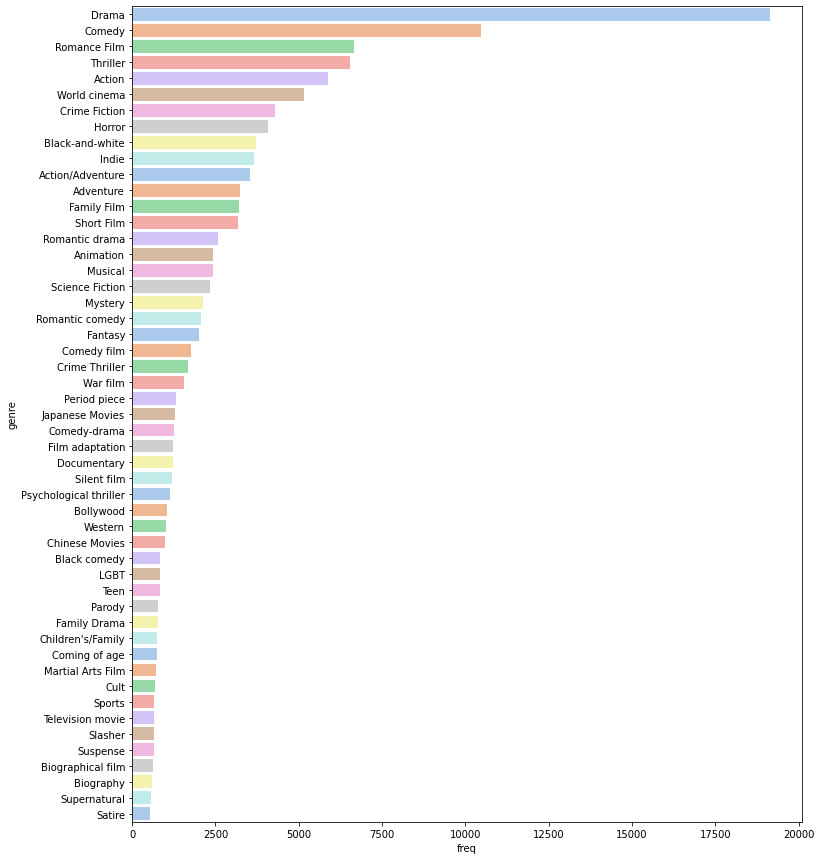

In [13]:
## Plotting the firsts 50th of movie genre frequency

plt.figure(figsize=(12,15))
#sns.color_palette("pastel")
ax = sns.barplot(data = feq_genre_df.iloc[:51,:], x = "freq", y = "genre", palette="pastel")
plt.show()


In [14]:
def clean_summary_text(text):
    # first: remove backslash-apostrophe
    text = re.sub("\'", "", text)
    
    # Second: maintaing only alphabets
    text = re.sub("[^a-zA-Z]"," ", text)

    #Third:# remove whitespaces 
    text = ' '.join(text.split()) 
    
    # convert text to lowercase 
    text = text.lower() 
    
    return text 

summary_df['clear_summary'] = summary_df['summary'].apply(lambda x: clean_summary_text(x))

In [15]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word", palette = "crest") 
  ax.set(ylabel = 'Word') 
  plt.show()

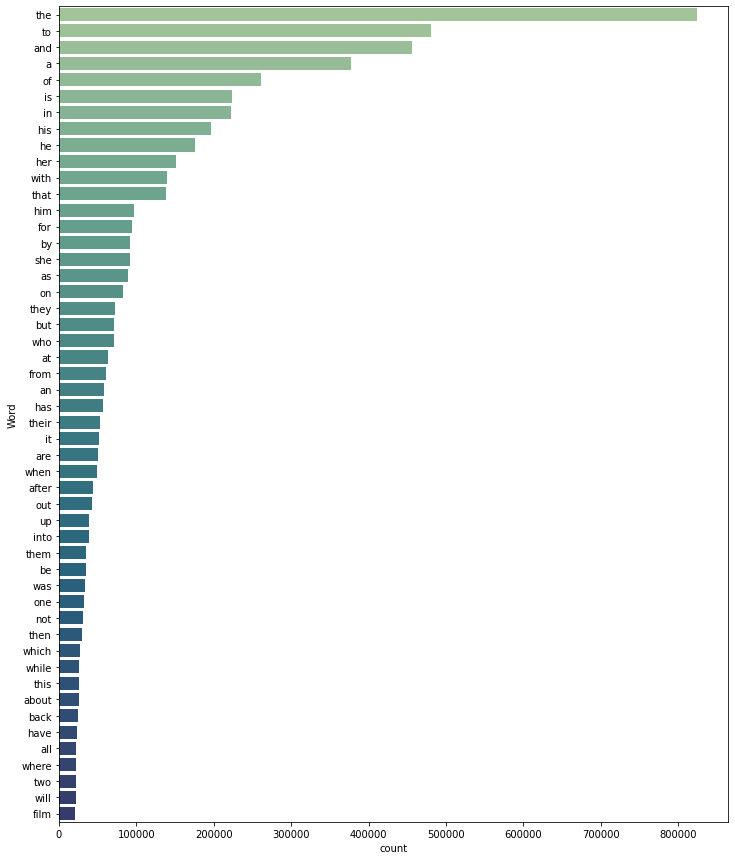

In [16]:
 freq_words(summary_df['clear_summary'], 50)

#### Created a matrix target

In [36]:
def created_target(tool_input, df_input, df_output):
    
    tool_01 = tool_input 
    tool_01.fit(df_input)

    # Extract the target matrix 
    y = tool_01.transform(df_output)

    return y,tool_01 


target, convert_target_tool = created_target(MultiLabelBinarizer(), summary_df['genre_list'], summary_df['genre_list'])


#### Split data

In [37]:
x_train, x_test, y_train, y_test = train_test_split(summary_df['clear_summary'],target
                                                    ,test_size =0.2, random_state = 9)

#### Feature Engeenier

In [38]:
def fet_eng(tool_fun, df_train, df_test):
    fd_convert = tool_fun.fit_transform(df_train)
    fd_convert2 = tool_fun.transform(df_test)
    return fd_convert, fd_convert2

# apply tool tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

#apply function
x_train_tfidf, x_test_tfidf = fet_eng(tfidf_vectorizer, x_train, x_test)

#### ML Train

In [39]:
x_train

14651    ibrahim is a year old muslim born in belgium h...
11764    miu a fishmonger at the prosperity market beca...
41886    an attempt to survey the mysterons planet mars...
8340     everyone is employed by the ultra modern dice ...
747      sang man cha tae hyun attempts to commit suici...
                               ...                        
25725    mara is married to vietnam veteran donny who h...
5014     a woman dancing provocatively to the enjoyment...
22584    the national team of the democratic republic o...
501      the movies plot shares a lot in common with gh...
20828    the plot revolves around the return of brian w...
Name: clear_summary, Length: 33763, dtype: object

In [40]:
x_train_tfidf

<33763x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 4473237 stored elements in Compressed Sparse Row format>

In [41]:
def build_train_alg(model,x,y,):
    alg_0 = model
    clf = OneVsRestClassifier(alg_0)

    #train
    clf.fit(x,y)
    
    return clf

model_01 = build_train_alg(LogisticRegression(),x_train_tfidf,y_train)

/home/samuel/anaconda3/envs/nlp_env_001/lib/python3.9/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/samuel/anaconda3/envs/nlp_env_001/lib/python3.9/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 281 is present in all training examples.
  warnings.warn(
/home/samuel/anaconda3/envs/nlp_env_001/lib/python3.9/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 307 is present in all training examples.
  warnings.warn(


In [45]:
def predict_output(clf,x_test):
    output = clf.predict(x_test)
    output_prob = clf.predict_proba(x_test)

    return output, output_prob

output, output_prob = predict_output(model_01,x_test_tfidf)

In [34]:
output[6]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [43]:
convert_target_tool.inverse_transform(output)[3]

('Drama',)

In [44]:
f1_score(y_test, output, average="micro")

0.3137414896600964

x_train

In [54]:
# threshold value
t = 0.3 

y_pred_new = (output_prob >= t).astype(int)

f1_score(y_test, y_pred_new, average="micro")

0.4402337093240282

In [53]:
y_pred_new

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
summary_df

,movie_id,summary,movie_name,genre,genre_list,clear_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]",shlykov a hard working taxi driver and lyosha ...
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr...",the nation of panem consists of a wealthy capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]",poovalli induchoodan is sentenced for six year...
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[Screwball comedy, Comedy]",the lemon drop kid a new york city swindler is...
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, Docudrama, World cinema...",seventh day adventist church pastor michael ch...
...,...,...,...,...,...,...
42199,34808485,"The story is about Reema , a young Muslim scho...",Oomakkuyil Padumbol,"{""/m/0bj8m2"": ""Children's""}",[Children's],the story is about reema a young muslim school...
42200,1096473,"In 1928 Hollywood, director Leo Andreyev look...",The Last Command,"{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...","[Silent film, Indie, Black-and-white, Period p...",in hollywood director leo andreyev looks throu...
42201,35102018,American Luthier focuses on Randy Parsons’ tra...,Randy Parsons: American Luthier,"{""/m/02hmvc"": ""Short Film"", ""/m/04rlf"": ""Music...","[Short Film, Music, Biographical film, Documen...",american luthier focuses on randy parsons tran...
42202,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Kabuliwala,"{""/m/07s9rl0"": ""Drama""}",[Drama],abdur rehman khan a middle aged dry fruit sell...


#### Feature engenieer

In [32]:
len(target[0])

27

##

In [21]:

stop_words = set(stopwords.words('english'))

In [22]:
text = summary_df['clear_summary'][0]
no_stopword_text = [w for w in text.split() if not w in stop_words]

In [24]:
no_stopword_text


['shlykov',
 'hard',
 'working',
 'taxi',
 'driver',
 'lyosha',
 'saxophonist',
 'develop',
 'bizarre',
 'love',
 'hate',
 'relationship',
 'despite',
 'prejudices',
 'realize',
 'arent',
 'different']

In [25]:
summary_df['clear_summary'][0].split()

['shlykov',
 'a',
 'hard',
 'working',
 'taxi',
 'driver',
 'and',
 'lyosha',
 'a',
 'saxophonist',
 'develop',
 'a',
 'bizarre',
 'love',
 'hate',
 'relationship',
 'and',
 'despite',
 'their',
 'prejudices',
 'realize',
 'they',
 'arent',
 'so',
 'different',
 'after',
 'all']

In [19]:
#https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

In [20]:
re.sub("\'", "", summary_df['summary'][0])

'Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they arent so different after all.'

In [21]:
re.sub("[^a-zA-Z]"," ", summary_df['summary'][0])

'Shlykov  a hard working taxi driver and Lyosha  a saxophonist  develop a bizarre love hate relationship  and despite their prejudices  realize they aren t so different after all '

In [22]:
_ = re.sub("\'", "", summary_df['summary'][0])
_ = re.sub("[^a-zA-Z]"," ", _ )

_

'Shlykov  a hard working taxi driver and Lyosha  a saxophonist  develop a bizarre love hate relationship  and despite their prejudices  realize they arent so different after all '

In [23]:
_ = ' '.join(_.split()) 

In [24]:
_

'Shlykov a hard working taxi driver and Lyosha a saxophonist develop a bizarre love hate relationship and despite their prejudices realize they arent so different after all'